# src_1

Now I'm using the the fluid as incompressible, and with the density of water.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os
import re

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [80]:
# output directory
# dir = '../data.lbm/1/'
dir = '../src/1/output.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

print(ticks)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570]


# Fluido

In [83]:
fluidDf = pd.read_csv(dir + f"fluidTrj_{ticks[30]}.csv").set_index(["id_x","id_y"]).sort_index()

fluidDf

tick  time  coordinate_x  coordinate_y  massDensity  \
id_x id_y                                                        
1    1      300  30.0         -20.0         -20.0          0.0   
     2      300  30.0         -20.0         -19.9          0.0   
     3      300  30.0         -20.0         -19.8          0.0   
     4      300  30.0         -20.0         -19.7          0.0   
     5      300  30.0         -20.0         -19.6          0.0   
...         ...   ...           ...           ...          ...   
401  397    300  30.0          20.0          19.6          0.0   
     398    300  30.0          20.0          19.7          0.0   
     399    300  30.0          20.0          19.8          0.0   
     400    300  30.0          20.0          19.9          0.0   
     401    300  30.0          20.0          20.0          0.0   

           fluidVelocity_x  fluidVelocity_y   f1   f2   f3   f4   f5   f6  \
id_x id_y                                                                   
1    1                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     2                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     3                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     4                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     5                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                    ...              ...  ...  ...  ...  ...  ...  ...   
401  397               0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     398               0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     399               0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     400               0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     401               0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   

            f7   f8   f9  
id_x id_y                 
1    1     0.0  0.0  0.0  
     2     0.0  0.0  0.0  
     3     0.0  0.0  0.0  
     4     0.0  0.0  0.0  
     5     0.0  0.0  0.0  
...        ...  ...  ...  
401  397   0.0  0.0  0.0  
     398   0.0  0.0  0.0  
     399   0.0  0.0  0.0  
     400   0.0  0.0  0.0  
     401   0.0  0.0  0.0  

[160801 rows x 16 columns]

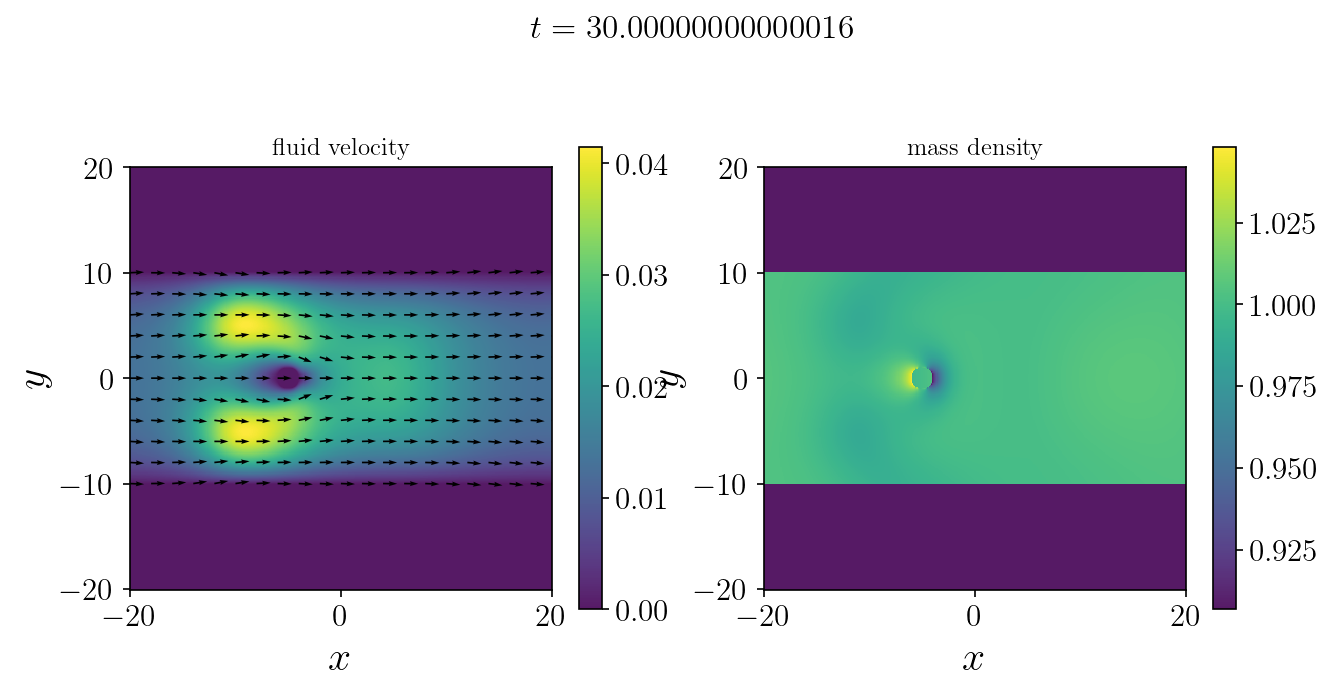

In [84]:
fig, axes = plt.subplots(1, 2, figsize = (10,5))

# Add a title for the whole figure
fig.suptitle(f"$t = {fluidDf.time.values[0]}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = fluidDf['coordinate_x'].unique()
y_unique = fluidDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

c = axes[0].pcolormesh(X, Y,
    np.sqrt(fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2).unstack().values.transpose(),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[0].set_title('fluid velocity')

maskStep = int(len(x_unique)/20)
# Create a mask for filtering
mask = (fluidDf['coordinate_x'].isin(x_unique[::maskStep])) & (fluidDf['coordinate_y'].isin(y_unique[::maskStep])) & (
    (fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2 > 1e-16)
)
# Filter the DataFrame
filtered_df = fluidDf[mask]

axes[0].quiver(
    filtered_df['coordinate_x'], 
    filtered_df['coordinate_y'], 
    (filtered_df.fluidVelocity_x / np.sqrt(filtered_df.fluidVelocity_x**2 + filtered_df.fluidVelocity_y**2)),
    (filtered_df.fluidVelocity_y / np.sqrt(filtered_df.fluidVelocity_x**2 + filtered_df.fluidVelocity_y**2)),
    scale = 30,
)

c = axes[1].pcolormesh(X,Y,
    fluidDf.massDensity.unstack().values.transpose(),
    vmin=min(fluidDf.query("massDensity > 0").massDensity.values),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[1].set_title('mass density')

for i in range(len(axes)):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary

plt.show()

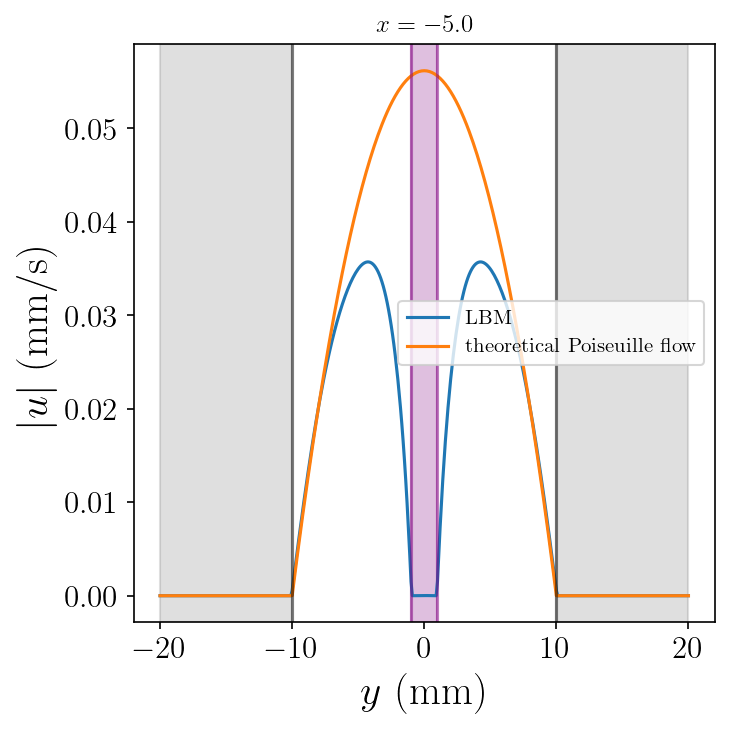

In [85]:
F = 1e-3 # force density units
h = 10 # mm
rho = 1 # water density units
nu = 0.890 # (mm)²/(s)

v_x = fluidDf.query("coordinate_x == -5").filter(["coordinate_x","coordinate_y","fluidVelocity_x","fluidVelocity_y"])
poiseuille_v = -F/(2*rho*nu) * (v_x.coordinate_y**2 - h**2); poiseuille_v = (poiseuille_v + abs(poiseuille_v))/2


fig, ax = plt.subplots(figsize = (5,5))

ax.plot(v_x.coordinate_y, np.sqrt(v_x.fluidVelocity_x**2 + v_x.fluidVelocity_y**2), label='LBM') 
ax.plot(v_x.coordinate_y, poiseuille_v, label='theoretical Poiseuille flow') 
ax.set_xlabel("$y$ (mm)")
ax.set_ylabel("$|u|$ (mm/s)")
ax.set_title(f"$x = {v_x.coordinate_x.values[0]}$")
ax.axvline(-10, color = "k", alpha = 0.5)
ax.axvline(10, color = "k", alpha = 0.5)
ax.axvspan(-20, -10, color='gray', alpha=0.25)  # Shade the wall
ax.axvspan(20, 10, color='gray', alpha=0.25)  # Shade the wall
ax.axvline(-1, color = "purple", alpha = 0.5)
ax.axvline(1, color = "purple", alpha = 0.5)
ax.axvspan(-1, 1, color='purple', alpha=0.25)  # Shade the wall
# ax.legend(loc='upper right')
ax.legend()

plt.show()

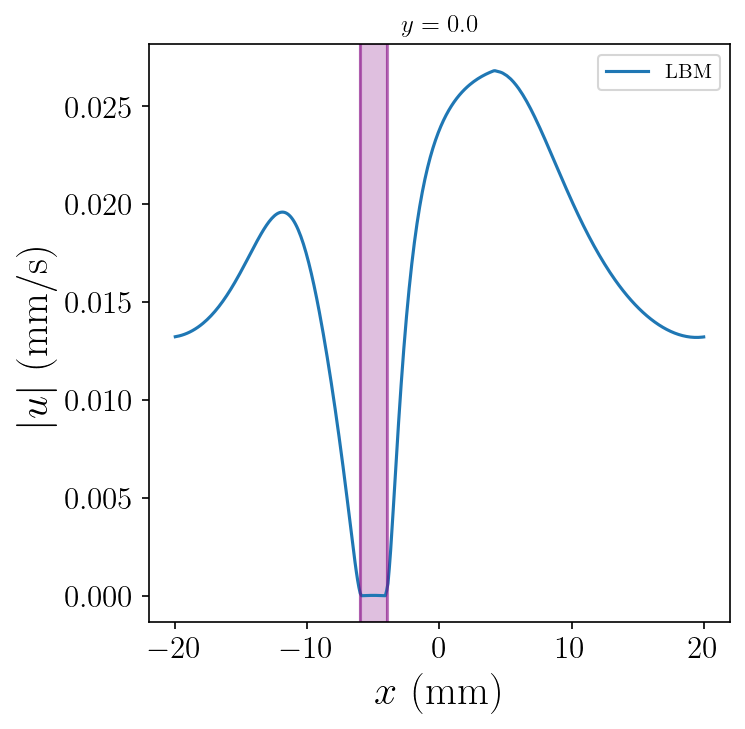

In [86]:
v_x = fluidDf.query("coordinate_y == 0").filter(["coordinate_x", "coordinate_y", "fluidVelocity_x", "fluidVelocity_y"])

fig, ax = plt.subplots(figsize = (5,5))

ax.plot(v_x.coordinate_x, np.sqrt(v_x.fluidVelocity_x**2 + v_x.fluidVelocity_y**2), label='LBM') 
ax.set_xlabel("$x$ (mm)")
ax.set_ylabel("$|u|$ (mm/s)")
ax.set_title(f"$y = {v_x.coordinate_y.values[0]}$")
ax.axvline(-1-5, color = "purple", alpha = 0.5)
ax.axvline(1-5, color = "purple", alpha = 0.5)
ax.axvspan(-1-5, 1-5, color='purple', alpha=0.25)  # Shade the wall
# ax.legend(loc='upper right')
ax.legend()

plt.show()

In [87]:
def maxSpeed(df):
    return np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).max()

maximumFluidSpeed = [
    maxSpeed(pd.read_csv(dir + f"fluidTrj_{tick}.csv"))
for tick in ticks]
time = [pd.read_csv(dir + f"fluidTrj_{tick}.csv").time.values[0] for tick in ticks]

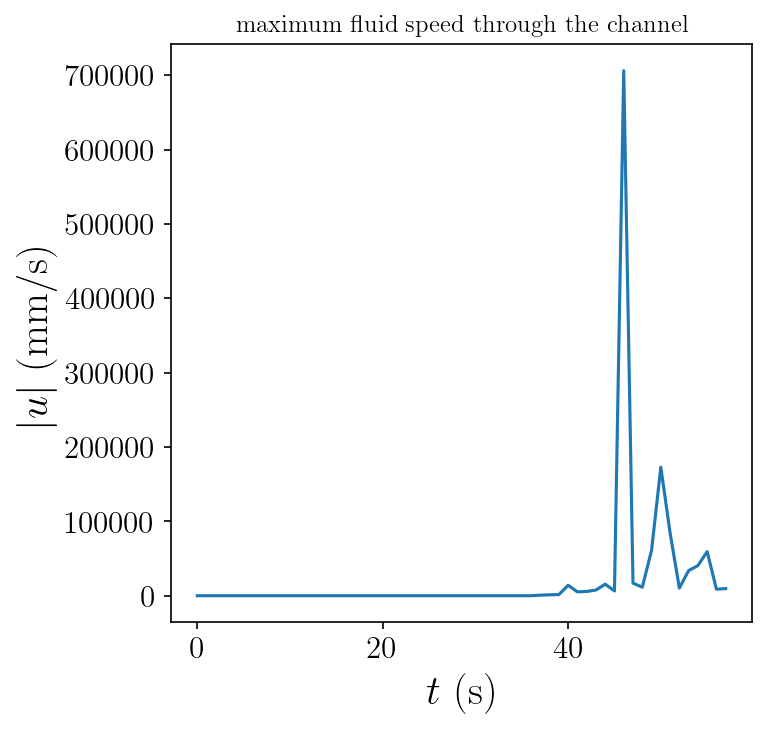

In [88]:
fig, ax = plt.subplots(figsize = (5,5))

ax.plot(time, maximumFluidSpeed)
ax.set_title("maximum fluid speed through the channel")
ax.set_xlabel("$t$ (s)")
ax.set_ylabel("$|u|$ (mm/s)")

plt.show()

# Tensor de estrés

In [10]:
stressDf = pd.read_csv(dir + "stressTensor.csv").set_index(["id_x","id_y"]).sort_index()

stressDf

tick   time  coordinate_x  coordinate_y  component_xx  \
id_x id_y                                                          
1    1     1000  100.0         -10.0         -10.0          -0.0   
     2     1000  100.0         -10.0          -9.9          -0.0   
     3     1000  100.0         -10.0          -9.8          -0.0   
     4     1000  100.0         -10.0          -9.7          -0.0   
     5     1000  100.0         -10.0          -9.6          -0.0   
...         ...    ...           ...           ...           ...   
201  197   1000  100.0          10.0           9.6          -0.0   
     198   1000  100.0          10.0           9.7          -0.0   
     199   1000  100.0          10.0           9.8          -0.0   
     200   1000  100.0          10.0           9.9          -0.0   
     201   1000  100.0          10.0          10.0          -0.0   

           component_yx  component_xy  component_yy  
id_x id_y                                            
1    1             -0.0          -0.0          -0.0  
     2             -0.0          -0.0          -0.0  
     3             -0.0          -0.0          -0.0  
     4             -0.0          -0.0          -0.0  
     5             -0.0          -0.0          -0.0  
...                 ...           ...           ...  
201  197           -0.0          -0.0          -0.0  
     198           -0.0          -0.0          -0.0  
     199           -0.0          -0.0          -0.0  
     200           -0.0          -0.0          -0.0  
     201           -0.0          -0.0          -0.0  

[40401 rows x 8 columns]

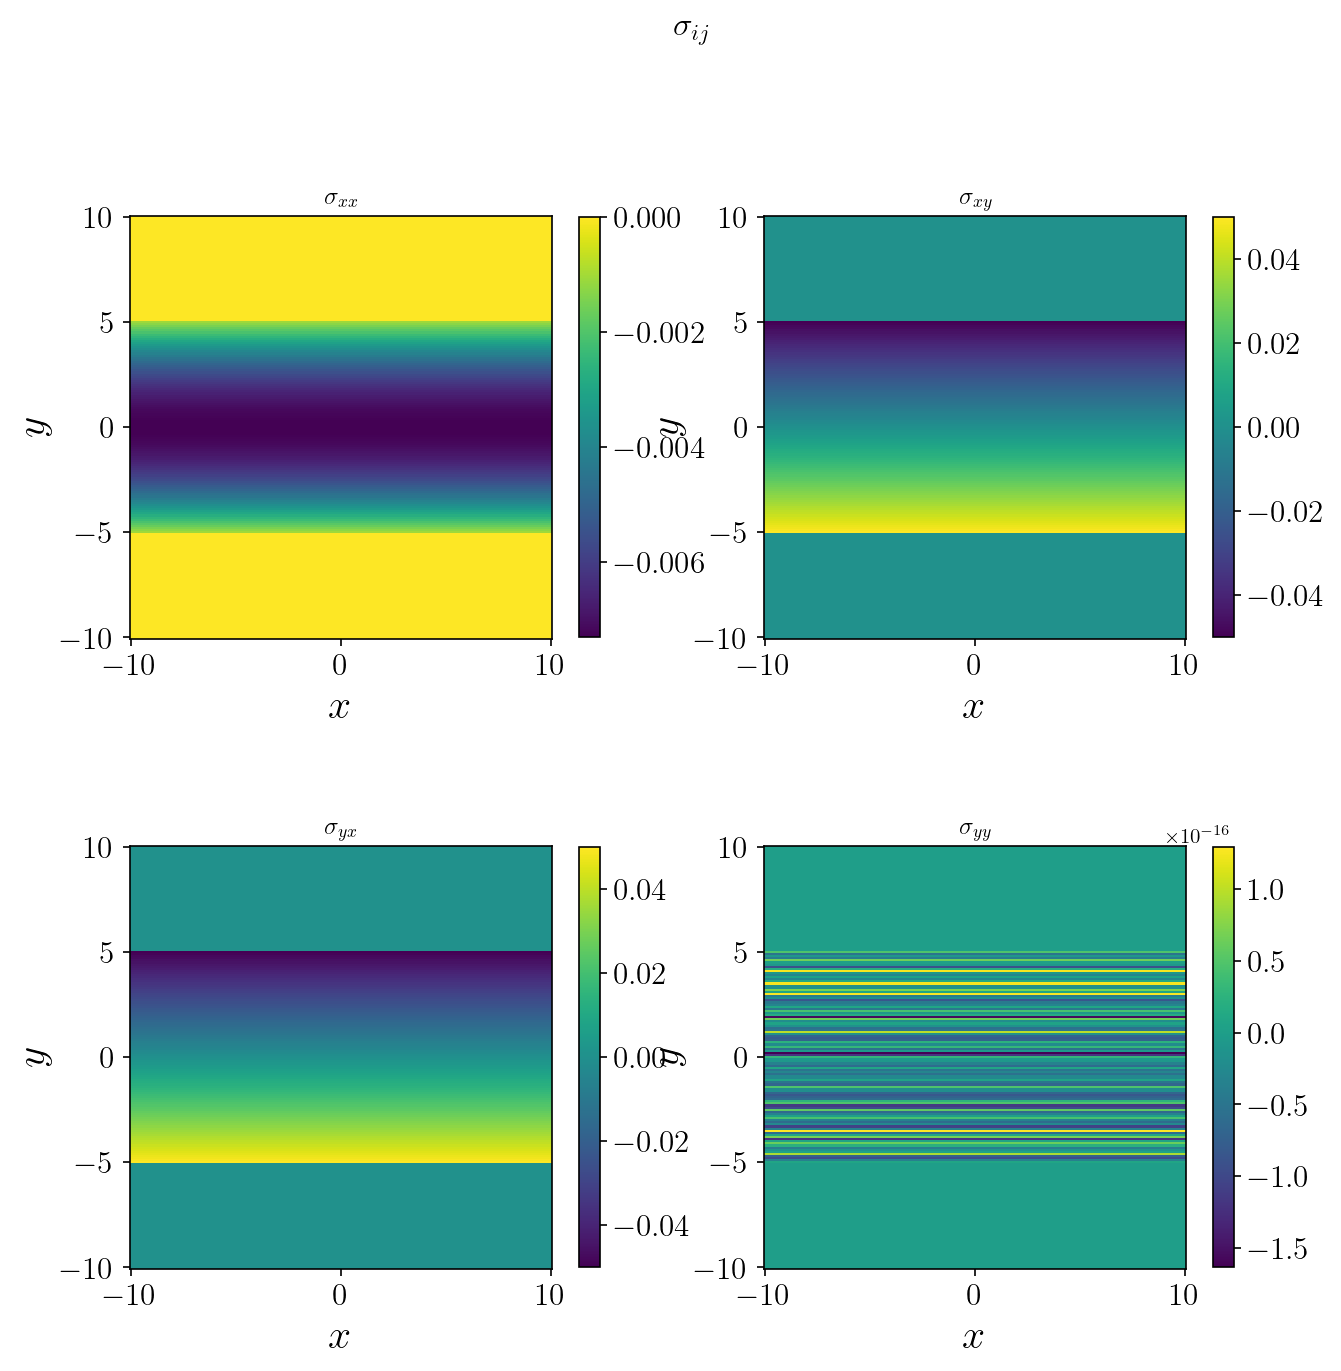

In [11]:
# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = stressDf['coordinate_x'].unique()
y_unique = stressDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

# plotting
c = axes[0,0].pcolormesh(X,Y,stressDf["component_xx"].unstack().values.transpose()); cs.append(c);
axes[0,0].set_title("$\\sigma_{xx}$")

c = axes[0,1].pcolormesh(X,Y,stressDf["component_xy"].unstack().values.transpose()); cs.append(c);
axes[0,1].set_title("$\\sigma_{xy}$")

c = axes[1,0].pcolormesh(X,Y,stressDf["component_yx"].unstack().values.transpose()); cs.append(c);
axes[1,0].set_title("$\\sigma_{yx}$")

c = axes[1,1].pcolormesh(X,Y,stressDf["component_yy"].unstack().values.transpose()); cs.append(c);
axes[1,1].set_title("$\\sigma_{yy}$")


# for ax in axes.flat:
for i in range(4):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")    
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary
#     ax.axhline(wallPosition, color = "k", alpha = 0.1)
#     ax.axhspan(-2, wallPosition, color='gray', alpha=0.1)  # Shade the wall

plt.show()